![title](qrisp_logo.png)

# QAOA Workshop

In this hands-on workshop you will be guided through the process to easily design the [Quantum Approximate Optimization Algorithm](https://arxiv.org/abs/1411.4028) and run it using Eclipse Qrisp. Throughout this tutorial you will be exposed to some unique, useful features available in Eclipse Qrisp, which make the programmers life much easier.

After getting the hang of the basic theoretical fundamentals including the structure, operation, and the functions of the phase separator and mixer Hamiltonians in QAOA, you will get to use it in practice.

The focus of this notebook will not be explaining the algorithm using rigorous math, but instead on using the algorithm to solve two specific problem instances: MaxCut and Max-$\kappa$-Colorable-Subgraph, as well as showcasing how to simply convert QUBO matrices $Q$ into circuits using the `QAOAProblem` class. For a more in-depth theoretical explanation of the inner workings of the algorithm check out the [QAOA tutorial](https://qrisp.eu/general/tutorial/Quantum%20Alternating%20Operator%20Ansatz/Theoretical.html).

**Table of contents:**
 
1.1  QAOA in a nutshell
 
    1.1.1  Close your eyes and imagine...
 
1.2  Solving MaxCut with QAOAProblem
 
    1.2.1  Building QAOA step by step
 
    1.2.2  Solving MaxCut with QAOAProblem
 
1.3  Solving Max-$\kappa$-Colorable-Subgraph with QAOAProblem
 
    1.3.1  From QuantumVariable to QuantumColor
 
    1.3.2  Tackling M$\kappa$CS
 
1.4  Solving QUBO problems using QAOAProblem
 
    1.4.1  Solving the Set Partitioning problem

## QAOA in a nutshell

The Quantum Approximate Optimization Algorithm is a hybrid quantum-classical variational algorithm designed for solving combinatorial optimization problems.

The quantum and classical part work together iteratively: the quantum computer prepares a quantum state and measures it, producing a classical output; this output is then fed into a classical optimization routine which produces new parameters for the quantum part. This process is repeated until the algorithm converges to an optimal or near-optimal solution.

### Close your eyes and imagine...

Let's momentarily imagine we're somewhere on the beach, far far away from the frozen Berlin sidewalks, staring into the distance, observing waves, enjoying the moment...

You've spent a couple of days of vacation on the beach observing how people masterfully manage to catch waves. You checked out all youtube beginner surf tutorials about how to position yourself on the board, you checked the ocean conditions and decided that this is the day when you succeed!

A couple of minutes ago you went to the rental shop and asked for a specific board suitable for beginners and the current conditions. With the surfboard under your arm and with a wetsuit equipped you run towards the beach like you've seen other surfers run in the days before.

Before the coastline you stop and stare into the distance, observing the superposition of waves closing in, and being happy that you found the courage to do this...
![title](surfer_on_beach.jpg)
 
... to solve optimization problems using the Eclipse Qrisp QAOA implementation!

If one squints hard enough with just enough imagination, one gets to see that running QAOA is exactly like surfing for the very first time! 

In order to catch a wave we first need to swim out into the superposition of waves. The surfers first try of the session is analogous to the **initial state** we feed the algorithm. In most cases this is, like stated above, just the superposition state $|s\rangle$.


While imagining the scene you also defined the **classical cost function** of the problem, which is akin to the current ocean conditions.

With doing research and watching all those tutorials you also defined the **cost operator** $U_P$, which showcases your ability to read the waves.

Lastly, you were recommended a speficic **mixer operator** $U_M$ in the surfshop, which is most suitable for tackling the existing conditions (classical cost function).

After starting in superposition $|s\rangle$ we then apply parameterized operators $U_P(\gamma_i)$ and $U_M(\beta_i)$ $p$ times before measuring the final state 

$$|\psi_p\rangle=|\boldsymbol\gamma,\boldsymbol\beta\rangle=U_M(B,\beta_p)U_P(C,\gamma_p)\cdots U_M(B,\beta_1)U_P(C,\gamma_1)|s\rangle.$$ 

The values of the parameters $\gamma$ and $\beta$ are analogous to surfer's position on the board, and the timing of the surfer's paddle. After each try (layer) the parameter values are optimized using a classical COBYLA optimizer. Those optimized values are then used in the next attempt (layer), yielding a better solution.

We clearly see how the optimization works here: we are continously refining the technique ($\gamma$ and $\beta$ parameters) in order to achieve the optimal solution. After enough attempts (layers) we finally succesfully catch a wave and surf to the shore! We have done it! 

In QAOA further refining the technique doesn't yield further improvement (although it's fun 🌊🤙🏻), however, it does require more and more resources, which is why carefully selecting the amount of layers $p$ is required. 

In Eclipse Qrisp there are plenty problem instances pre-defined to run using QAOA, three of which we'll run in the next sections.

PROBLEM INSTANCE | MIXER TYPE | IMPLEMENTED
:--:|:--:|:--:
MaxCut | X mixer | ✅
Max-$\ell$-SAT | X mixer | ✅
QUBO | X mixer | ✅
MaxIndependentSet | Controlled X mixer | ✅
MaxClique | Controlled X mixer | ✅
MaxSetPacking | Controlled X mixer | ✅
MinSetCover | Controlled X mixer | ✅
Max$\kappa$-Colorable-Subgraph | XY mixer | ✅


## Solving MaxCut with QAOAProblem

We can now apply concepts from the daydream above and
a) build the QAOA algorithm layer by layer, and 
b) use the high-level approach using the QAOAProblem class to solve MaxCut.

Let's first import the necessary packages, define the graph for which we'll solve MaxCut, and swim into the ocean to reach the initial superposition state.

### Building QAOA step by step

QuantumCircuit:
---------------
      ┌───┐
qv.0: ┤ H ├
      ├───┤
qv.1: ┤ H ├
      ├───┤
qv.2: ┤ H ├
      ├───┤
qv.3: ┤ H ├
      ├───┤
qv.4: ┤ H ├
      ├───┤
qv.5: ┤ H ├
      └───┘
Live QuantumVariables:
----------------------
QuantumVariable qv


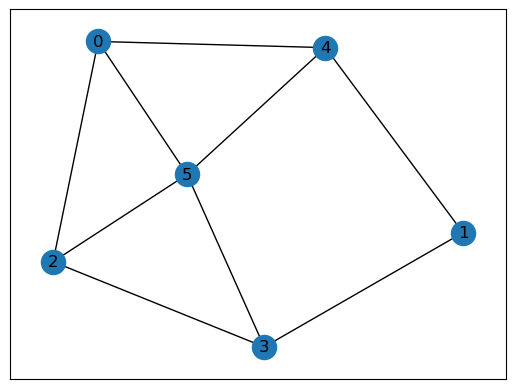

In [16]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from qrisp import *


G = nx.random_tree(6)

# Add additional edges to make the graph more interconnected
# The number of additional edges
for _ in range(4):
    while True:
        # Pick two different nodes at random
        node1, node2 = random.sample(list(G.nodes), 2)
              
        # Check if an edge already exists between these nodes or if it's a self-loop
        if G.has_edge(node1, node2) or node1 == node2:
            continue
              
        # Add an edge between these nodes
        G.add_edge(node1, node2)
        break
        
nx.draw_networkx(G)

N = len(G)

qv = QuantumVariable(N)

h(qv)

print(qv.qs)


As we see, we achieve the superposition state $|s\rangle$ by applying the Hadammard gate to each qubit.

Now we can continue building the first layer of our QAOA algorithm by applying the cost operator. From literature we know, that the cost operator for MaxCut is

$$U_P=e^{-i\gamma H_P}=e^{-i\gamma\sum_{i,j\in G}Z_iZ_j}$$

For Pauli matrices we then calculate this as 

$$ \begin{align}\begin{split}e^{-i\theta Z}&=R_Z(2\theta)=\begin{pmatrix}e^{-i\theta}&0\\0&e^{i\theta}\end{pmatrix}\end{split}\end{align} $$

The $ZZ$ gate can also be achieved by a pair of $CNOT$ gates and a $R_Z$ gate. 

In [2]:
from qrisp import cx, rz, barrier
from sympy import Symbol

gamma = Symbol('γ')

def apply_cost_operator(qv, gamma):
    for pair in list(G.edges()):
        cx(qv[pair[0]], qv[pair[1]])
        rz(2 * gamma, qv[pair[1]])
        cx(qv[pair[0]], qv[pair[1]])
        #rzz(2*gamma, qv[pair[0]], qv[pair[1]])
        barrier(qv)
    return qv

qv = apply_cost_operator(qv, gamma)

print(qv.qs)

QuantumCircuit:
---------------
      ┌───┐                      ░                       ░                 »
qv.0: ┤ H ├──■───────────────■───░───■───────────────■───░───■─────────────»
      ├───┤  │               │   ░   │               │   ░ ┌─┴─┐┌─────────┐»
qv.1: ┤ H ├──┼───────────────┼───░───┼───────────────┼───░─┤ X ├┤ Rz(2*γ) ├»
      ├───┤┌─┴─┐┌─────────┐┌─┴─┐ ░   │               │   ░ └───┘└─────────┘»
qv.2: ┤ H ├┤ X ├┤ Rz(2*γ) ├┤ X ├─░───┼───────────────┼───░─────────────────»
      ├───┤└───┘└─────────┘└───┘ ░   │               │   ░                 »
qv.3: ┤ H ├──────────────────────░───┼───────────────┼───░─────────────────»
      ├───┤                      ░ ┌─┴─┐┌─────────┐┌─┴─┐ ░                 »
qv.4: ┤ H ├──────────────────────░─┤ X ├┤ Rz(2*γ) ├┤ X ├─░─────────────────»
      ├───┤                      ░ └───┘└─────────┘└───┘ ░                 »
qv.5: ┤ H ├──────────────────────░───────────────────────░─────────────────»
      └───┘                      ░          

For educational reasons, let's try calling the $ZZ$ gate directly instead, and observe the more compact, yet analogous circuit:

In [3]:
def apply_cost_operator(qv, gamma):
    for pair in list(G.edges()):
        rzz(2*gamma, qv[pair[0]], qv[pair[1]])
        barrier(qv)
    return qv

qv = QuantumVariable(N)
h(qv)
qv = apply_cost_operator(qv, gamma)

print(qv.qs)

QuantumCircuit:
---------------
      ┌───┐           ░            ░            ░            ░            ░ »
qv.0: ┤ H ├─■─────────░──■─────────░──■─────────░────────────░────────────░─»
      ├───┤ │         ░  │         ░  │ZZ(2*γ)  ░            ░            ░ »
qv.1: ┤ H ├─┼─────────░──┼─────────░──■─────────░──■─────────░──■─────────░─»
      ├───┤ │ZZ(2*γ)  ░  │         ░            ░  │         ░  │         ░ »
qv.2: ┤ H ├─■─────────░──┼─────────░────────────░──┼─────────░──┼─────────░─»
      ├───┤           ░  │         ░            ░  │ZZ(2*γ)  ░  │         ░ »
qv.3: ┤ H ├───────────░──┼─────────░────────────░──■─────────░──┼─────────░─»
      ├───┤           ░  │ZZ(2*γ)  ░            ░            ░  │         ░ »
qv.4: ┤ H ├───────────░──■─────────░────────────░────────────░──┼─────────░─»
      ├───┤           ░            ░            ░            ░  │ZZ(2*γ)  ░ »
qv.5: ┤ H ├───────────░────────────░────────────░────────────░──■─────────░─»
      └───┘           ░         

By following the same steps one can also build the mixer. In this case we are using the $X$-mixer operator:

In [4]:
from qrisp import rx

beta = Symbol('β')

def apply_mixer(qv, beta):
    for i in range(0, N):
        rx(2 * beta, qv[i])
    barrier(qv)
    return qv

qv = apply_mixer(qv, beta)

print(qv.qs)

QuantumCircuit:
---------------
      ┌───┐           ░            ░            ░            ░            ░ »
qv.0: ┤ H ├─■─────────░──■─────────░──■─────────░────────────░────────────░─»
      ├───┤ │         ░  │         ░  │ZZ(2*γ)  ░            ░            ░ »
qv.1: ┤ H ├─┼─────────░──┼─────────░──■─────────░──■─────────░──■─────────░─»
      ├───┤ │ZZ(2*γ)  ░  │         ░            ░  │         ░  │         ░ »
qv.2: ┤ H ├─■─────────░──┼─────────░────────────░──┼─────────░──┼─────────░─»
      ├───┤           ░  │         ░            ░  │ZZ(2*γ)  ░  │         ░ »
qv.3: ┤ H ├───────────░──┼─────────░────────────░──■─────────░──┼─────────░─»
      ├───┤           ░  │ZZ(2*γ)  ░            ░            ░  │         ░ »
qv.4: ┤ H ├───────────░──■─────────░────────────░────────────░──┼─────────░─»
      ├───┤           ░            ░            ░            ░  │ZZ(2*γ)  ░ »
qv.5: ┤ H ├───────────░────────────░────────────░────────────░──■─────────░─»
      └───┘           ░         

And voila! The first QAOA to solve MaxCut is here. One could now write a function to apply $p$ layers, which exactly what we'll do!

In [5]:
p = 3

def apply_p_layers(qv, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta)
    h(qv)
    for i in range(p):
        apply_cost_operator(qv, gamma[i])
        apply_mixer(qv, beta[i])
    barrier(qv)
    return qv

In order to adjust the parameters $\gamma$ and $\beta$ we need to first find a way to differentiate good solutions from bad solutions. We are looking for a cut going through as much edges as possible. It’s therefore crucial to count the amount of cuts we cut through by checking if the nodes $i$ and $j$ belong to different groups. If they are, the edge is cut and added to the total. This shall be our objective: to find the maximal amount of such cuts.

In [6]:
def maxcut_obj(x):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            cut -= 1
    return cut

The cost function is important for keeping track of the energy of the system.

We loop over the measurement in `meas_res`. Each solution is represented by a string of 1 and 0 in `meas` with probability $p$ keeping score in how likely a particular solution appears.

For each such solution the cost is calculated using the `maxcut_obj` returning the number of cut edges. 

At the end, `maxcut_cost_funct` calculates the average “quality” of a set of solutions to the MaxCut problem. A lower average energy means that, on average, the solutions are better - they cut more edges.

In [7]:
def maxcut_cost_funct(meas_res):
    energy = 0
    for meas, p in meas_res.items():
        obj_for_meas = maxcut_obj(meas)
        energy += obj_for_meas * p
    return energy

With our $p$-layered algorithm in hand there is one last piece of the puzzle: the objective function, which we need to generate in order to calculate the average energy of the resulting solutions. Oh, and it features the angle parameters $\gamma$ and $\beta$, which we combine in one list `theta`. 

The solutions we get depend on the values of the angle parameters.

In [8]:
def quantum_objective(theta):
    qv_p = QuantumVariable(N)
    beta = theta[:p]
    gamma = theta[p:]
    qv = apply_p_layers(qv_p,beta, gamma)
    results = qv.get_measurement()
    return maxcut_cost_funct(results)

We can finally finish combine all the pieces of the mosaic and have it appraised by a professional - a classical optimizer. 

We first reset the initial state and randomize it in a list where the first $p$ values correspond to $\beta$ and the second one to $\gamma. It has finally come the time to inclute the COBYLA optimiser, which will return the optimal parameters that minimze our objective function. This is done using the `minimize` method, which adjusts the parameters iteratively until it finds the best ones.

Then, once we have our optimal parameters, we apply QAOA one more time to get our final set of solutions (`counts`), before finding the best solution by looking for the one with the lowest energy. Finally, we visualize our solution by coloring the nodes of our graph according to which group they belong to in the best solution.

Best string: 011010 with cut: 7                                              | [  0%]


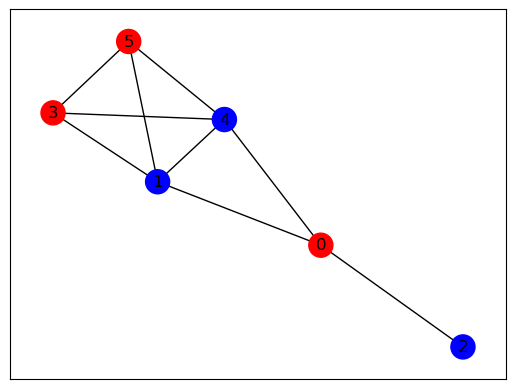

In [9]:
import numpy as np
from scipy.optimize import minimize
from operator import itemgetter

init_point = np.pi * np.random.rand(2 * p)

res_sample = minimize(quantum_objective, init_point, method='COBYLA', options={'maxiter':50})

optimal_theta = res_sample['x']
qv_p = QuantumVariable(N)
qv = apply_p_layers(qv_p, optimal_theta[:p], optimal_theta[p:])
counts = qv_p.get_measurement()

best_cut, best_solution = min([(maxcut_obj(x),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw_networkx(G, node_color = colors)

### Solving MaxCut with QAOAProblem

Taking the essential building blocks into account, we built the `QAOAProblem` class with modularity in mind. We gathered and improved the functions shown in the example above and created a powerfull architecture with which it’s easy to implement various problem instances of varying complexity.In this tutorial we focus on using `QAOAProblem`, with extensive documentation being [available here](https://www.qrisp.eu/reference/Algorithms/QAOA.html#qaoa).

We start with renaming our quantum argument `qv` to a more general `qarg` because more often than not we’ll combine QuantumVariables into a QuantumArray to make implementations of other problem instances more efficient.

Best string: ['0' '1' '1' '0' '1' '0'] with cut: 7                           | [  0%]


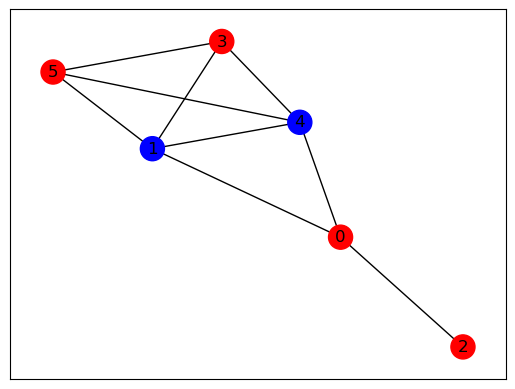

In [10]:
from qrisp.qaoa import QuantumArray, QuantumVariable, QAOAProblem, maxcut_obj,create_maxcut_cl_cost_function,create_maxcut_cost_operator, RX_mixer
import networkx as nx
from operator import itemgetter

qarg = QuantumArray(qtype = QuantumVariable(1), shape = len(G))

depth = 5

maxcut_instance = QAOAProblem(create_maxcut_cost_operator(G), RX_mixer, create_maxcut_cl_cost_function(G))

res = maxcut_instance.run(qarg, depth, max_iter = 50)

best_cut, best_solution = min([(maxcut_obj(x,G),x) for x in res.keys()], key=itemgetter(0))

res_str = list(res.keys())[0]
print(f"Best string: {best_solution} with cut: {-best_cut}")
best_cut, best_solution = (maxcut_obj(res_str,G),res_str)

colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw_networkx(G, node_color = colors)

We see that we got a solution just as good (if not exactly the same), but with much less coding since all of the functions come pre-defined in Eclipse Qrisp.

## Solving Max-$\kappa$-Colorable-Subgraph with `QAOAProblem`

The Max-$\kappa$-Colorable Subgraph involves finding the largest subgraph of a given graph that can be colored using $\kappa$ colors, such that no two adjacent nodes share the same color. 

MaxCut is considered as a special case of graph coloring for $\kappa=2$ and therefore, after solving it with QAOA in the previous tutorial, provides us with a solid starting point for understanding graph coloring. The skills and knowledge you’ve gained are directly applicable here, but we’ll also introduce new concepts and techniques to tackle the added complexity of using more than two colors.

You will explore how to formulate the M$\kappa$CS problem, implement the algorithm, and interpret the results. Along the way you'll likely realize that programming in Qrisp isn’t a mundane black-and-white task, but rather a vibrant experience offering a whole spectrum of possibilities.


### From QuantumVariable to <span style="color:red">Q</span><span style="color:orange">u</span><span style="color:yellow">a</span><span style="color:green">n</span><span style="color:blue">t</span><span style="color:indigo">u</span><span style="color:violet">m</span><span style="color:red">C</span><span style="color:orange">o</span><span style="color:yellow">l</span><span style="color:green">o</span><span style="color:blue">r</span>

We start the tutorial by coding the <span style="color:red">Q</span><span style="color:orange">u</span><span style="color:yellow">a</span><span style="color:green">n</span><span style="color:blue">t</span><span style="color:indigo">u</span><span style="color:violet">m</span><span style="color:red">C</span><span style="color:orange">o</span><span style="color:yellow">l</span><span style="color:green">o</span><span style="color:blue">r</span> class, which is a custom QuantumType and helps with tackling the Max-$\kappa$-Colorable-Subgraph problem. It provides flexibility in choosing encoding methods and leverages efficient data structures like QuantumArrays to enhance computational performance. Here is how to create a custom QuantumVariable class yourself to help you make your problem more compact.

In order to create your customized QuantumVariable, one first needs to import the QuantumVariable class. As mentioned before, using the QuantumArray class leads to some shortcuts so let's import it as well. Before defining the class and functions within the class let's think about how one can describe or encode colors using strings of bits:

- One approach is to represent colors as an array where only one element is 1 and the rest are 0. For instance, if there are four colors, <span style="color:red">red</span><span style="color:black">, </span><span style="color:green">green</span><span style="color:black">, </span><span style="color:blue">blue</span><span style="color:black">, and </span><span style="color:yellow">yellow</span><span style="color:black">, they can be represented this way as </span><span style="color:red">[1, 0, 0, 0]</span><span style="color:black">, </span><span style="color:green">[0, 1, 0, 0]</span><span style="color:black">, </span><span style="color:blue">[0, 0, 1, 0]</span><span style="color:black">, and </span><span style="color:yellow">[0, 0, 0, 1]</span><span style="color:black">. This is called the **one-hot encoding**. 
- Another approach is to represent colors with a unique binary number. In the case of the same four colors, they can be represented, for example, as </span><span style="color:red">[0, 0]</span><span style="color:black">, </span><span style="color:green">[0, 1]</span><span style="color:black">, </span><span style="color:blue">[1, 0]</span><span style="color:black">, and </span><span style="color:yellow">[1, 1]</span><span style="color:black"> respectively. This encoding scheme is called **binary encoding**. 
    
In the code block below, we can define the initialization function `__init__` as well as find a way to tell our quantum algorithm which color is encoded with our array. In other words, we need to define a decoder function that will decode the color for a given index `i`. In our case we use the one-hot encoding scheme as default. 

In [11]:
from qrisp import QuantumArray, QuantumVariable
import numpy as np

class QuantumColor(QuantumVariable):

    def __init__(self, list_of_colors, one_hot_enc = True): 
        
        self.list_of_colors = list_of_colors
        self.one_hot_enc = one_hot_enc

        if one_hot_enc:
            QuantumVariable.__init__(self, size = len(list_of_colors)) 
        else:
            QuantumVariable.__init__(self, size = int(np.ceil(np.log2(len(list_of_colors)))))

    def decoder(self, i):
        
        if not self.one_hot_enc:
            return self.list_of_colors[i]
        else:
            is_power_of_two = ((i & (i-1) == 0) and i != 0)

            if is_power_of_two:
                return self.list_of_colors[int(np.log2(i))]
            else:
                return "undefined"

The `else` condition returning "undefined" can come in extremely handy since it functions as an intuitive eye-test in the upcoming MkCS QAOA implementation. If any result of the simulation is "undefined", like [1, 0, 1, 0] for example, we know that something went wrong within our code.

The choice of encoding method has implications for how colors are represented in the quantum computation. Our simple QuantumColor class only needs a list of colors and a flag indicating the preferred encoding method as arguments. The breakdown above is meant to serve as inspiration for you, showcasing how custom QuantumVariables tailored to one specific problem can make life at least a little qubit more colorful.

Having already implemented this custom QuantumVariable, you can also simply import it via `from qrisp.qaoa import QuantumColor`. In the example above we define a quantum box of crayons containing different colors. If one would then like to draw a meadow, one can take the green one out of the box and initialize a color using `box_of_crayons[:] = "green"`. 

Run the code box below and see how that works with our custom QuantumVariable.

In [12]:
from qrisp.qaoa import QuantumColor

color_list = ["red", "orange", "yellow", "green", "blue", "violet"]
box_of_crayons = QuantumColor(color_list)
box_of_crayons[:] = "green"
print(box_of_crayons.qs)

QuantumCircuit:
---------------
box_of_crayons.0: ─────
                       
box_of_crayons.1: ─────
                       
box_of_crayons.2: ─────
                  ┌───┐
box_of_crayons.3: ┤ X ├
                  └───┘
box_of_crayons.4: ─────
                       
box_of_crayons.5: ─────
                       
Live QuantumVariables:
----------------------
QuantumColor box_of_crayons


### Tackling M$\kappa$CS

We could go through brainstorming how to define the objective, objective function, coloring operator, setting the initial state, and running the algorithm like we did with MaxCut (we did that in the [online tutorial](https://www.qrisp.eu/general/tutorial/Quantum%20Alternating%20Operator%20Ansatz/MkCS.html)), but we can skip all that by importing the predefined problem specific functions an just solve the problem. Run the cell below and color your world.

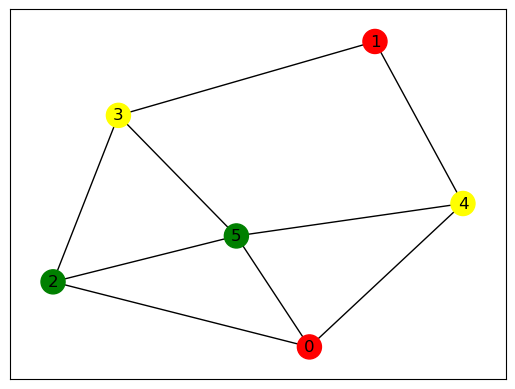

In [17]:
from qrisp.qaoa import QuantumArray, QuantumColor, QAOAProblem, mkcs_obj, create_coloring_operator, create_coloring_cl_cost_function, apply_XY_mixer
import random
import networkx as nx
from operator import itemgetter
import matplotlib.pyplot as plt

depth = 3

#G = nx.Graph()
#G.add_edges_from([[0,1],[0,4],[1,2],[1,3],[1,4],[2,3],[3,4]])
num_nodes = len(G.nodes)
color_list = ["red", "blue", "yellow", "green"]
init_state = [random.choice(color_list) for _ in range(len(G))]

qarg = QuantumArray(qtype = QuantumColor(color_list, one_hot_enc = True), shape = num_nodes) 
mkcs_onehot = QAOAProblem(create_coloring_operator(G), apply_XY_mixer, create_coloring_cl_cost_function(G))
mkcs_onehot.set_init_function(lambda x : x.encode(init_state))

res_onehot = mkcs_onehot.run(qarg, depth, max_iter = 25)

best_coloring, best_solution = min([(mkcs_obj(quantumcolor_array,G),quantumcolor_array) for quantumcolor_array in res_onehot.keys()], key=itemgetter(0))
best_coloring_onehot, res_str_onehot = min([(mkcs_obj(quantumcolor_array,G),quantumcolor_array) for quantumcolor_array in list(res_onehot.keys())[:5]], key=itemgetter(0))
best_coloring_onehot, best_solution_onehot = (mkcs_obj(res_str_onehot,G),res_str_onehot)

nx.draw_networkx(G, node_color = res_str_onehot, with_labels=True)

In case the graph above is colored in a way that no two neighboring nodes share the same color woohoo and congrats! If not, try running the algorithm again - the first 'A' in QAOA stands for "Aproximate" after all! Try also adjusting the depth of the circuit, as well as the number of iterations for the COBYLA optimizer.

If you would like to color a bigger graph, you can edit the first code block to generate it and then run this cell again - important to note: every additional node costs 4 qubits because of the one-hot encoding we used. One could also try out the binary encoding? What would change? If you want to try out binary encoding edit the last code block with the commented lines of code found [on the QAOA reference site](https://www.qrisp.eu/reference/Examples/QAOA.html#id4).

## Solving QUBO problems using `QAOAProblem`

This brings us to the feature we are excited to include in the upcoming 0.4 update. We all know that solving QUBO problems on quantum annealers was a staple in tackling problems since [A Tutorial on Formulating and Using QUBO Models](https://arxiv.org/abs/1811.11538) was published in 2018.

Authors in this paper explain how to derive QUBO Hamiltonians so we won't do that here. Basically, the end result of such an approach is minimizing the cost function $\min C(x)=\min x^TQx$ for binary variables $x_i\in\{0,1\}$. By sending the QUBO matrix $Q$ to the annealer/quantum computer, one then recieves the bitstrings with corresponding values of $C(x)$. The lower the $C(x)$, the better the solution.

In other words, we want to find the Hamiltonian $H_C$|x\rangle=C(x)|x\rangle$.

To construct such a circuit with quantum gates and run it on a quantum computer, one has to translate between the basis of $x_i$ to Pauli gate operators.

$$Z_i|x\rangle=(-1)^{x_i}\rightarrow\frac{\mathbb{1}-Z_i}{2}|x\rangle=x_i$$

To find $H_C$ one can calculate

$$\begin{align}\begin{split}H_C&=\sum_{i,j=1}^nQ_{ij}\frac{\mathbb{1}-Z_i}{2}\frac{\mathbb{1}-Z_j}{2}\\&=\sum_{i,j=1}^n\frac{Q_{ij}}{4}+\sum_{i,j}^n\frac{Q_{ij}}{4}Z_iZ_j\\&\space\space\space\space-\sum_{i=1}^n\bigg(\sum_{j=1}^n\frac{Q_{ij}}{4}\bigg)Z_i-\sum_{j=1}^n\bigg(\sum_{i=1}^n\frac{Q_{ij}}{4}\bigg)Z_j\\&\space\space\space\space\end{split}\end{align}$$

If we now gather all the single $Z_i$ together, we get$$\begin{align}\begin{split}H_C&=\frac{1}{4}\sum_{i,j=1}^nQ_{ij}Z_iZ_j-\frac{1}{2}\sum_{i=1}^n\sum_{j=1}^nQ_{ij}Z_i&+\frac{1}{4}\sum_{i,j=1}^nQ_{ij}\end{split}\end{align}$$

We mentioned how to now calculate the matrix exponential and how that corresponds to Pauli matrices.

For the cost operator that we feed into `QAOAProblem` we then get

$$\begin{align}\begin{split}e^{-i\gamma H_C}=&\prod_{i,j=1}^nR_{Z_iZ_j}\bigg(\frac{1}{4}Q_{ij}\gamma\bigg)\\+&\prod_{i=1}^nR_{Z_i}\Bigg(-\frac{1}{2}\bigg(\sum_{j=i}^nQ_{i                   j}+\frac{1}{2}\sum_{j\neq i}Q_{ij}\bigg)\gamma\Bigg)\end{split}\end{align}$$

Since this feature is not yet released, we can showcase how all the functions necessary to make `QAOAProblem` as high-level as it is.

In [14]:
from qrisp import rzz, rz
import numpy as np

def QUBO_obj(bitstring, Q):
    x = np.array(list(bitstring), dtype=int)
    cost = x.T @ Q @ x
    return cost

def create_QUBO_cl_cost_function(Q):

    def cl_cost_function(counts):
        
        def QUBO_obj(bitstring, Q):
            x = np.array(list(bitstring), dtype=int)
            cost = x.T @ Q @ x
            return cost
        
        energy = 0
        for meas, meas_count in counts.items():
            obj_for_meas = QUBO_obj(meas,Q)
            energy += obj_for_meas * meas_count
        return energy
    
    return cl_cost_function

def create_QUBO_cost_operator(Q):

    def QUBO_cost_operator(qv, gamma):
        
        for i in range(len(Q)):
            rz(-0.5*2*gamma*(0.5*Q[i][i]+0.5*sum(Q[i])), qv[i])
            for j in range(i+1, len(qv)):
                if Q[i][j] !=0:
                    rzz(0.25*2*gamma*Q[i][j], qv[i], qv[j])
    return QUBO_cost_operator


def QUBO_problem(Q,init_type='random'):

    from qrisp.qaoa import QAOAProblem, RX_mixer
    
    return QAOAProblem(create_QUBO_cost_operator(Q), RX_mixer, create_QUBO_cl_cost_function(Q),init_type=init_type)

With this implementation we can now solve the QUBO problem for any QUBO matrix $Q$.

### Solving the Set Partitioning problem using QUBO$\rightarrow$QAOA

Let us use the example from the above mentioned publication to test the implementation:

*The set partitioning problem (SPP) has to do with partitioning a set of items into subsets so that each item appears in exactly one subset and the cost of the subsets chosen is minimized. This problem appears in many settings including the airline and other industries and is traditionally 
formulated in binary variables as*

$$\min\sum_{j=1}^nc_jx_j\space\space\text{subject to}\space\space \sum_{j=1}^na_{ij}x_j=1\space\space\text{for}\space\space i=1,\dots,m$$

*Where $x_j$ denotes whether or not subset $j$ is chosen, $c_j$ is the cost of subject $j$, and the $a_{ij}$ coefficients are $0$ or $1$ whether or not variable $x_j$ explicitly appears in constraint $i$.*

More specifically, the authors then provide a numerical example of a set partitioning problem $\min y=3x_1+2x_2+x_3+x_4+3x_5+2x_6$ subject to the following constraints 

$$\begin{align}\begin{split}&x_1+x_3+x_6=1\\&x_2+x_3+x_5+x_6=1\\&x_3+x_4+x_5=1\\&x_1+x_2+x_4+x_6=1\end{split}\end{align}$$

After adding penalty terms and other QUBO magic, one then obtains the QUBO model $\min x^T Q x$ where $x$ is a binary variable, and $Q$ is the so called QUBO matrix

$$Q = \begin{pmatrix}&-17&10&10&10&0&20\\&10&-18&10&10&10&20\\&10&10&-29&10&20&20\\&10&10&10&-19&10&10\\&0&10&20&10&-17&10\\&20&20&20&10&10&-28\end{pmatrix}$$

As said above, this is also everything we need in order to solve a QUBO problem.

In [15]:
from operator import itemgetter
import numpy as np

Q = np.array(
    [
        [-17,10,10,10,0,20],
        [10,-18,10,10,10,20],
        [10,10,-29,10,20,20],
        [10,10,10,-19,10,10],
        [0,10,20,10,-17,10],
        [20,20,20,10,10,-28],
    ]
)

bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]

cl_cost_function = create_QUBO_cl_cost_function(Q)

depth = 2   

qarg = QuantumArray(qtype = QuantumVariable(1), shape = len(Q))

cost_operator = create_QUBO_cost_operator(Q)

from qrisp.default_backend import def_backend

QUBO_instance = QAOAProblem(cost_operator, RX_mixer, cl_cost_function)
res = QUBO_instance.run(qarg, depth, mes_kwargs={"backend" : def_backend}, max_iter = 50)
best_cost, res_str = min([(QUBO_obj(bitstring, Q), bitstring) for bitstring in list(res.keys())], key=itemgetter(0))

print("Below you can find 5 best costs and their respective solutions:")
# Calculate the cost for each solution
costs_and_solutions = [(QUBO_obj(bitstring, Q), bitstring) for bitstring in res.keys()]

# Sort the solutions by their cost in ascending order
sorted_costs_and_solutions = sorted(costs_and_solutions, key=itemgetter(0))

# Get the top 10 solutions and print them
for i in range(10):
    print(f"Solution {i+1}: {sorted_costs_and_solutions[i][1]} with cost: {sorted_costs_and_solutions[i][0]}")

Below you can find 5 best costs and their respective solutions:              | [  0%]
Solution 1: ['1' '0' '0' '0' '1' '0'] with cost: -34
Solution 2: ['0' '0' '1' '0' '0' '0'] with cost: -29
Solution 3: ['0' '0' '0' '0' '0' '1'] with cost: -28
Solution 4: ['0' '0' '1' '1' '0' '0'] with cost: -28
Solution 5: ['0' '1' '1' '0' '0' '0'] with cost: -27
Solution 6: ['0' '0' '0' '1' '0' '1'] with cost: -27
Solution 7: ['1' '0' '1' '0' '0' '0'] with cost: -26
Solution 8: ['0' '0' '0' '0' '1' '1'] with cost: -25
Solution 9: ['0' '0' '0' '1' '0' '0'] with cost: -19
Solution 10: ['0' '1' '0' '0' '0' '0'] with cost: -18


We now get the list of the best solutions. Of course, it would be enough to print just the best one, but this way we can observe, if some of the best solutions, by chance, don't satisfy the constraints - in this case one should adapt the penalty factor in the original QUBO formulation and adjust the QUBO matrix $Q$ accordingly.

In the upcoming Eclipse Qrisp 0.4 release, one will obtain the printed list simply by caling `solution = solve_QUBO(Q, depth, backend)`. How easy is that?!